# Baseline Model based on U-Net

In [1]:
import os

# needed to get the path right
os.chdir("..")

## Training

In [2]:
from baseline.trainer import Trainer

trainer = Trainer()

Segmentation Models: using `tf.keras` framework.


In [3]:
model = trainer.get_model()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, None, None,  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, None, None, 3 9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, None, None, 3 0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, None, None, 6 9408        zero_padding2d[0][0]             
____________________________________________________________________________________________

In [7]:
%time history = trainer.train_from_simple_dataloader(dataset_size=10, batch_size=1, epochs=10)

Epoch 1/10
10/10 - 33s - loss: 1.6379 - iou_score: 0.2134 - val_loss: 1.6215 - val_iou_score: 0.1569
Epoch 2/10
10/10 - 29s - loss: 1.4035 - iou_score: 0.2720 - val_loss: 1.6162 - val_iou_score: 0.1449
Epoch 3/10
10/10 - 29s - loss: 1.2834 - iou_score: 0.3018 - val_loss: 1.6596 - val_iou_score: 0.1438
Epoch 4/10
10/10 - 29s - loss: 1.2000 - iou_score: 0.3235 - val_loss: 1.6751 - val_iou_score: 0.1564
Epoch 5/10
10/10 - 29s - loss: 1.1399 - iou_score: 0.3403 - val_loss: 1.6528 - val_iou_score: 0.1521
Epoch 6/10
10/10 - 29s - loss: 1.0992 - iou_score: 0.3513 - val_loss: 1.6227 - val_iou_score: 0.1428
Epoch 7/10
10/10 - 29s - loss: 1.0605 - iou_score: 0.3638 - val_loss: 1.6411 - val_iou_score: 0.1172
Epoch 8/10
10/10 - 28s - loss: 1.0250 - iou_score: 0.3758 - val_loss: 1.5712 - val_iou_score: 0.1772
Epoch 9/10
10/10 - 29s - loss: 0.9952 - iou_score: 0.3870 - val_loss: 1.6432 - val_iou_score: 0.1473
Epoch 10/10
10/10 - 29s - loss: 0.9707 - iou_score: 0.3950 - val_loss: 1.5886 - val_iou_sco

In [8]:
history.history['iou_score']

[0.21340923011302948,
 0.271962970495224,
 0.3018139898777008,
 0.323479562997818,
 0.3403124213218689,
 0.3513084352016449,
 0.36382797360420227,
 0.3757522702217102,
 0.3869834244251251,
 0.3950175642967224]

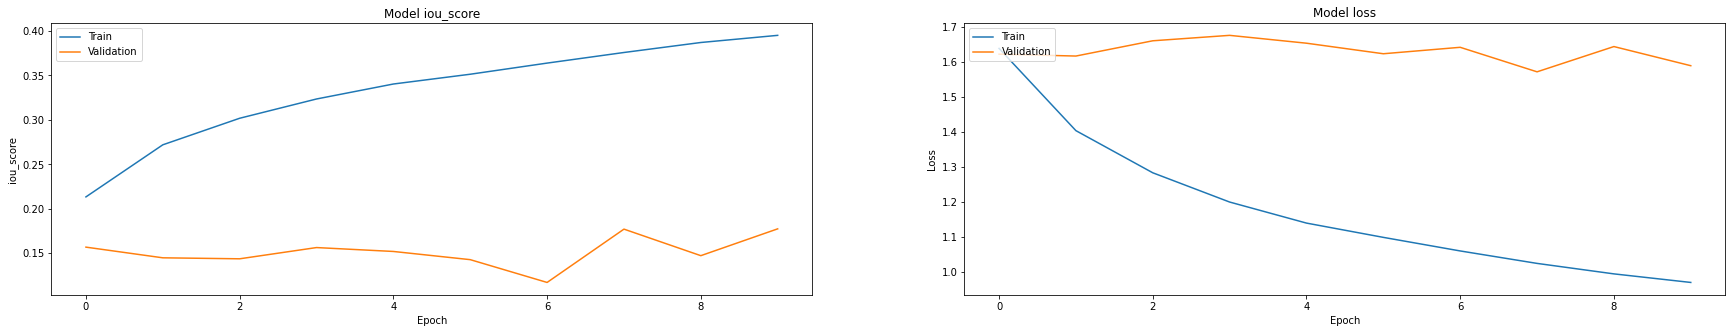

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Prediction

In [12]:
import segmentation_models as sm
from constants import TEST_DIR
from baseline.dataloader import SimpleDataLoader
from baseline.helper import Visualisation

simple_data_loader = SimpleDataLoader(
    backbone=Trainer.BACKBONE,
    images_path=os.path.join(TEST_DIR, "images"),
    size=10
)

test_images = simple_data_loader.get_images()

(512, 512, 3)
(1, 512, 512, 3)


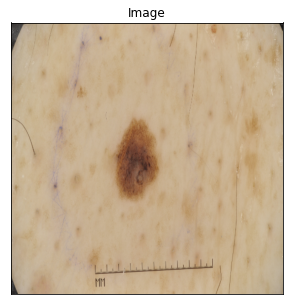

In [18]:
import numpy as np

test_image = test_images[1]

print(test_image.shape)
test_image = np.expand_dims(test_image, axis=0)  # add batch dimension
print(test_image.shape)

Visualisation().show(image=test_image.squeeze())

In [14]:
predicted_mask = model.predict(test_image).round()
print(predicted_mask.shape)

(1, 512, 512, 1)


In [15]:
predicted_mask[..., 0].shape

(1, 512, 512)

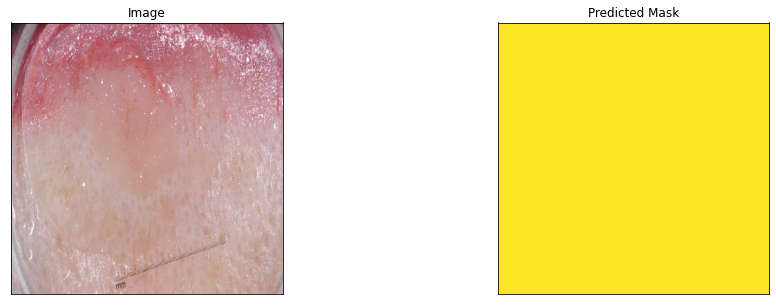

In [16]:
Visualisation().show(
    image=test_image.squeeze(),
    predicted_mask=predicted_mask[..., 0].squeeze()
)

(1, 512, 512, 3)
(1, 512, 512, 1)


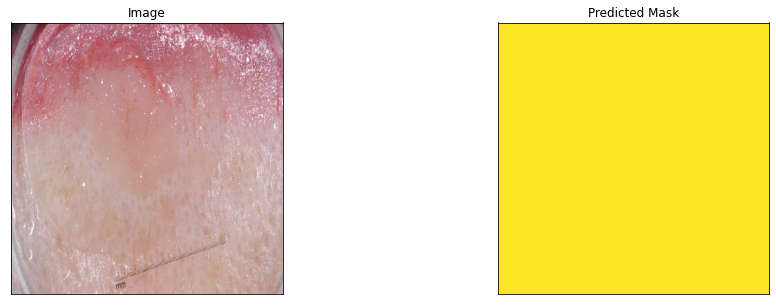

(1, 512, 512, 3)
(1, 512, 512, 1)


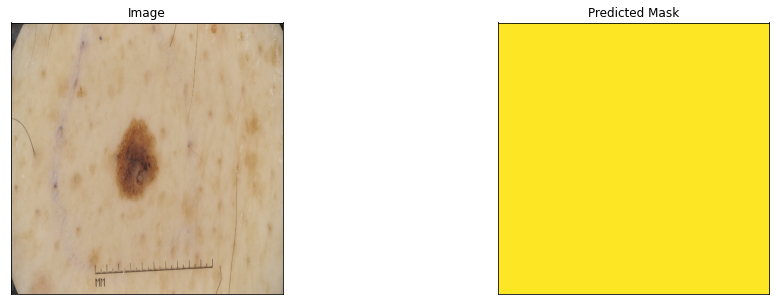

(1, 512, 512, 3)
(1, 512, 512, 1)


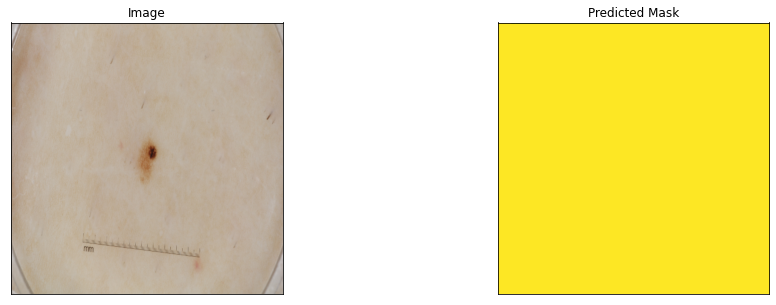

In [17]:
for test_image in simple_data_loader.get_images()[:3]:
    test_image = np.expand_dims(test_image, axis=0)
    print(test_image.shape)
    predicted_mask = model.predict(test_image).round()
    print(predicted_mask.shape)
    
    Visualisation().show(
        image=test_image.squeeze(),
        predicted_mask=predicted_mask[..., 0].squeeze()
    )